<a href="https://colab.research.google.com/github/ryanreilly/phase_5_capstone/blob/main/ResNet50_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#This cell is connecting to my google drive and loading the train, validation and test folders. 
from google.colab import drive
!unzip drive/MyDrive/train.zip
!unzip drive/MyDrive/dev.zip
!unzip drive/MyDrive/test.zip

In [2]:
#This cell is showing me what GPU Google is giving me. 
train_dir = 'train'
validation_dir = 'dev'
test_dir = 'test'

In [ ]:
#Chech to see what GPU Google cloud gave me
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

In [4]:
#Import Libraries

#For manipulating and visualizing images
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import itertools


#To load an image using Keras
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import optimizers, models, applications
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model, load_model

#To plot confusion matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

#to track how long the models run
import datetime

#For dividing the images into correct folders
import shutil
import os

#To ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [8]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
            
validation_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
#Create train and validation generators
train_generator_res = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')

validation_generator_res = validation_datagen.flow_from_directory(validation_dir, 
                                                              target_size=(224, 224), 
                                                              batch_size=32, 
                                                              class_mode='categorical',
                                                              shuffle=False)

Found 12422 images belonging to 7 classes.
Found 1458 images belonging to 7 classes.


In [10]:
#Build the model
resnet = ResNet50(
    input_shape= (224,224,3),
    include_top=False,
    weights='imagenet')


resnet.trainable = False

# Define Model Architecture
X = resnet.output
X = Flatten()(X)
X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Dense(256, activation='relu')(X)
outputs = Dense(7, activation='softmax')(X)

model_resnet = Model(resnet.input, outputs)

for layer in resnet.layers:
    layer.trainable = False


opt = optimizers.Adam(learning_rate=0.00001)
model_resnet.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


history_4 = model_resnet.fit_generator(generator= train_generator_res,
                                    epochs= 20, 
                                    validation_data= validation_generator_res, 
                                    validation_steps=1)

94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/20
389/389 [==============================] - 293s 707ms/step - loss: 1.7542 - accuracy: 0.3142 - val_loss: 1.5875 - val_accuracy: 0.3750
Epoch 2/20
389/389 [==============================] - 275s 706ms/step - loss: 1.6710 - accuracy: 0.3537 - val_loss: 1.6027 - val_accuracy: 0.4688
Epoch 3/20
389/389 [==============================] - 274s 705ms/step - loss: 1.6411 - accuracy: 0.3748 - val_loss: 1.6480 - val_accuracy: 0.4062
Epoch 4/20
389/389 [==============================] - 274s 705ms/step - loss: 1.6321 - accuracy: 0.3791 - val_loss: 1.6402 - val_accuracy: 0.3750
Epoch 5/20
389/389 [==============================] - 272s 698ms/step - loss: 1.6164 - accuracy: 0.3867 - val_loss: 1.5910 - val_accuracy: 0.4062
Epoch 6/20
389/389 [==============================] - 269s 692ms/step - loss: 1.6123 - accuracy: 0.3925 - val_loss: 1.6716 - val_accuracy: 0.3438
Epoch 7/20
389/389 [==============================] - 270s 

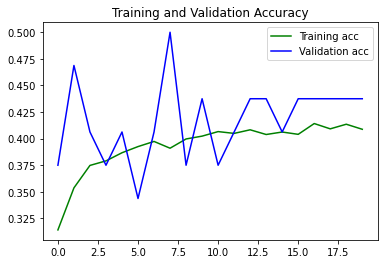

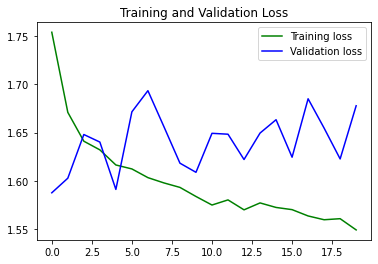

In [11]:
acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']
loss = history_4.history['loss']
val_loss = history_4.history['val_loss']
epochs = range(len(acc))


plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
test_generator_res = test_datagen.flow_from_directory(test_dir, 
                                                              target_size=(224, 224), 
                                                              batch_size=32, 
                                                              class_mode='categorical',
                                                              shuffle=False)

Found 3147 images belonging to 7 classes.


In [14]:
y_pred = model_resnet.predict(test_generator_res, batch_size=32)
y_pred = np.argmax(y_pred, axis=1)

In [15]:
def plot_confusion_mat(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
    else:
      print('Confusion matrix, without normalization')


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [17]:
cm_plot_labels = [key for key,value in test_generator_res.class_indices.items()]
cm = confusion_matrix(test_generator_res.classes, y_pred)

Confusion matrix, without normalization


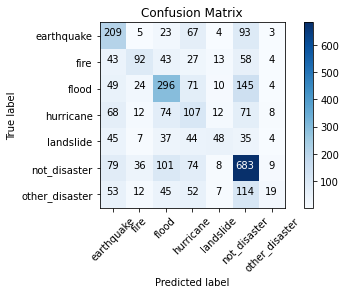

In [18]:
plot_confusion_mat(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [19]:
print(classification_report(test_generator_res.classes, y_pred, target_names = [key for key,value in test_generator_res.class_indices.items()]))

                precision    recall  f1-score   support

    earthquake       0.38      0.52      0.44       404
          fire       0.49      0.33      0.39       280
         flood       0.48      0.49      0.49       599
     hurricane       0.24      0.30      0.27       352
     landslide       0.47      0.22      0.30       220
  not_disaster       0.57      0.69      0.62       990
other_disaster       0.37      0.06      0.11       302

      accuracy                           0.46      3147
     macro avg       0.43      0.37      0.37      3147
  weighted avg       0.46      0.46      0.44      3147

